### Imports

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# custom packages
from ratsimulator import Agent, trajectory_generator, batch_trajectory_generator
from ratsimulator.Environment import Rectangle

import datetime
import sys
# avoid adding multiple relave paths to sys.path
sys.path.append("../src") if "../src" not in sys.path else None 

from Brain import Brain
from Models import UnitPathIntegrator, SorscherRNN
from methods import *

### Set parameters and initialise

In [3]:
"""
# Sorscher params
options.save_dir = '/mnt/fs2/bsorsch/grid_cells/models/'
options.n_steps = 100000      # number of training steps
options.batch_size = 200      # number of trajectories per batch
options.sequence_length = 20  # number of steps in trajectory
options.learning_rate = 1e-4  # gradient descent learning rate
options.Np = 512              # number of place cells
options.Ng = 4096             # number of grid cells
options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.RNN_type = 'RNN'      # RNN or LSTM
options.activation = 'relu'   # recurrent nonlinearity
options.weight_decay = 1e-4   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves
options.periodic = False      # trajectories with periodic boundary conditions
options.box_width = 2.2       # width of training environment
options.box_height = 2.2      # height of training environment
"""

params = {}
# Environment params
params['boxsize'] = (2.2, 2.2)
params['origo'] = (0,0)
params['soft_boundary'] = 0.2
# Brain params
params['npcs'] = 512 # as used in Sorscher model
params['pc_sigma'] = 0.12
params['DoG'] = True
# Training data (Agent) params
params['batch_size'] = 200
params['seq_len'] = 20
params['angle0'] = None # random
params['p0'] = None     # random
# Agent/random walk parameters
params['dt'] = 0.02
params['turn_sigma'] = 5.76 * 2
params['b'] = 0.13 * 2 * np.pi
params['mu'] = 0
# Model params
params['Ng'] = 4096
params['Np'] = params['npcs'] # defined for Brain already
params['weight_decay'] = 1e-4
params['lr'] = 1e-4# 1e-3 is default for Adam()
params['nsteps'] = 100 # number of mini batches in an epoch
params['nepochs'] = 1000 # number of epochs

# stuff
params['tag'] = 'default_with_training_metrics'
params['save_model'] = True 
params['save_freq'] = 1
params['date'] = datetime.datetime.now()

num_workers = 16
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Init Environment
env = Rectangle(boxsize=params['boxsize'], soft_boundary=params['soft_boundary'])
params['environment'] = type(env).__name__
# Init brain
brain = Brain(env, params['npcs'], params['pc_sigma'])
# Init training data
dataset = Dataset(brain=brain, batch_size=params['batch_size'], nsteps=params['nsteps'], \
                  environment=env, seq_len=params['seq_len'], angle0=params['angle0'], \
                  p0=params['p0'], dt=params['dt'], sigma=params['turn_sigma'], b=params['b'], \
                  mu=params['mu'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=params['batch_size'], num_workers=num_workers)
# Init model
model = SorscherRNN(params['Ng'],params['Np']) # UnitPathIntegrator(params['Ng'],params['Np'])
model.to(device)
print(model)
# Init optimizer (use custom weight decay, rather than torch optim decay)
optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], betas=(0.9, 0.999), \
                             eps=1e-08, weight_decay=0.0, amsgrad=False)

Singular matrix
Singular matrix
SorscherRNN(
  (init_position_encoder): Linear(in_features=512, out_features=4096, bias=False)
  (RNN): RNN(2, 4096, bias=False, batch_first=True)
  (decoder): Linear(in_features=4096, out_features=512, bias=False)
)


### Train Model

In [5]:
checkpoint_path = '../checkpoints/'
loss_history = []

if loaded_model:=True:
    model_name = type(model).__name__
    checkpoints = torch.load(f'{checkpoint_path}{model_name}_{params["tag"]}')
    model.load_state_dict(checkpoints['model_state_dict'])
    optimizer.load_state_dict(checkpoints['optimizer_state_dict'])
    loss_history = checkpoints['loss_history']
    training_metrics = checkpoints['training_metrics']
    print("Loaded weights")
    
# whether to train
if train:=False:
    loss_history = model.train(trainloader = dataloader, optimizer = optimizer, weight_decay=params['weight_decay'], \
                nepochs=params['nepochs'], loaded_model = loaded_model, \
                save_model = params['save_model'], save_freq = params['save_freq'], \
                loss_history = loss_history, tag = params['tag'], params = params)

Loaded weights


### Analyse Model

6.2383246250395095

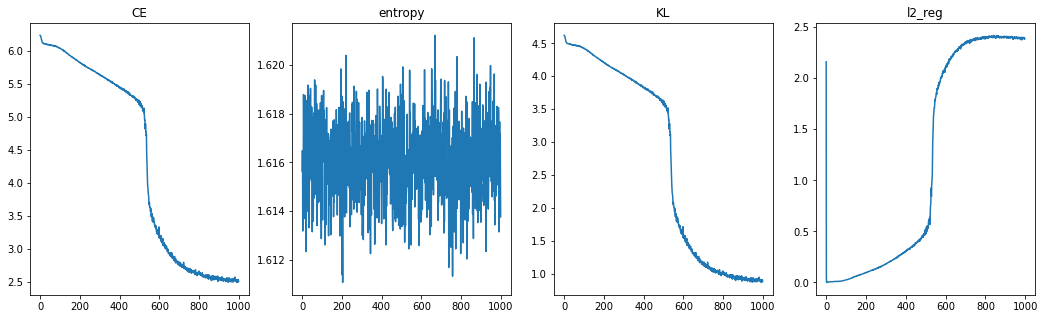

In [6]:
fig, ax = plt.subplots(ncols=4,figsize=(18,5))
for i,(key,value) in enumerate(checkpoints['training_metrics'].items()):
    if key == 'l2_reg':
        value = value[2:]
    ax[i].plot(value)
    ax[i].set_title(key)

# maximum labelled distribution entropy (uniform labelled distribution)
n = 512
px = np.ones(n) / n # uniform
entropy = lambda x: -np.sum(x * np.log(x))
entropy(px)

Text(0, 0.5, 'loss')

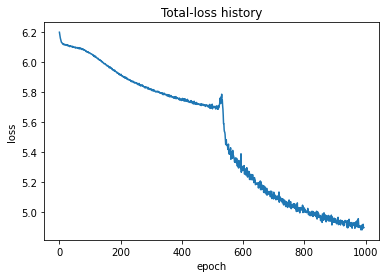

In [7]:
plt.plot(loss_history[5:])
plt.title('Total-loss history')
plt.xlabel('epoch')
plt.ylabel('loss')

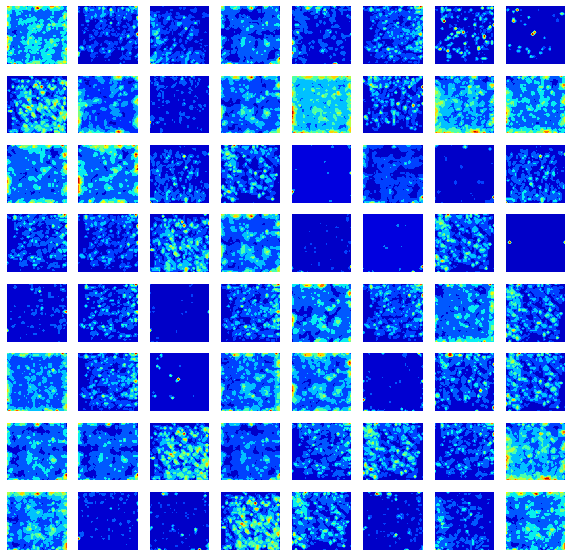

In [8]:
idxs=slice(0, 64*8, 8)
board, rate_maps, response_maps, count_maps = rate_map(model=model.g, environment=env, dataset=dataset, seq_len=params['seq_len'], \
              res=np.array([32, 32]), idxs=idxs, num_samples=1)
num_response_maps = int((idxs.stop - idxs.start) / idxs.step)

fig, ax = multicontourf(*board.T, rate_maps)

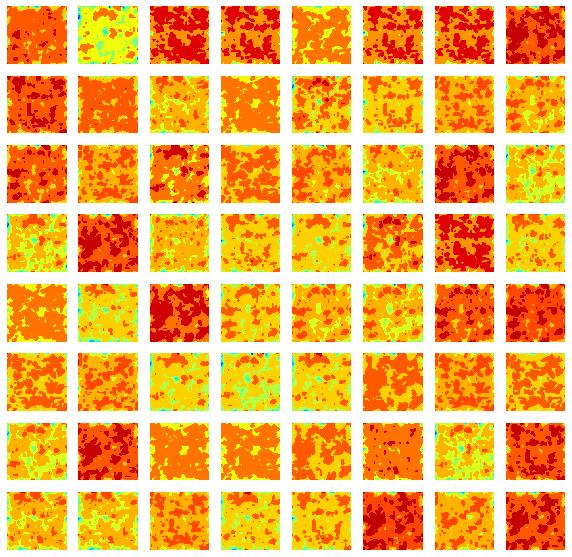

In [9]:
# learned place cells
# idxs=slice(0, 64, 1)
board, rate_maps, _, _ = rate_map(model=model, environment=env, dataset=dataset, seq_len=params['seq_len'], \
              res=np.array([32, 32]), idxs=idxs, num_samples=1)
num_response_maps = int((idxs.stop - idxs.start) / idxs.step)

fig, ax = multicontourf(*board.T, rate_maps)

### Decoding labels and predictions to cartesian

In [29]:
dataset.return_cartesian = True
[[vel, init_pos], labels, true_cartesian_pos] = dataset[1]
true_decoded_pos = brain.to_euclid(torch.cat([init_pos[None], labels]))
pc_preds = model([vel, init_pos]).detach().cpu()[0]
predicted_decoded_pos = brain.to_euclid(torch.cat([init_pos[None], pc_preds]))

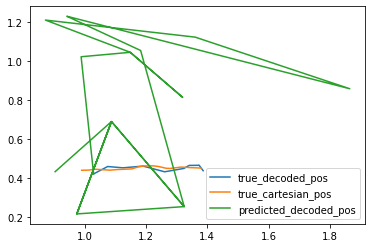

In [30]:
plt.plot(*true_decoded_pos.T, label='true_decoded_pos')
plt.plot(*true_cartesian_pos.T, label='true_cartesian_pos')
plt.plot(*predicted_decoded_pos.T, label='predicted_decoded_pos')
plt.legend()

### Small analysis / checks / tests etc

In [ ]:
# Wr = model.recurrence.weight.detach().cpu().numpy()
Wr = model.RNN.weight_hh_l0.detach().cpu().numpy()
stats = lambda W : print(f"{np.min(W)=}, {np.max(W)=}, {np.min(abs(W))=}, {np.mean(W)=}, {np.std(W)=}, {np.sum(W**2)=}")
stats(Wr)
plt.imshow(Wr[:25,:25])
plt.colorbar()

In [ ]:
Wp = model.init_position_encoder.weight.detach().cpu().numpy()
stats = lambda W : print(f"{np.min(W)=}, {np.max(W)=}, {np.min(abs(W))=}, {np.mean(W)=}, {np.std(W)=}, {np.sum(W**2)=}")
stats(Wp)
plt.imshow(Wp)
plt.colorbar()

In [ ]:
fig, ax = plt.subplots()
x,y = brain.pcs.T

ax.plot(x, y, "+")
# add standard deviation circles to locations
for i in range(5):
    ax.plot(x[i], y[i], "r+")
    a_circle = plt.Circle((x[i], y[i]), params['pc_sigma'], fill=False, color=(1, 0, 0, 0.5))
    ax.add_artist(a_circle)

plt.title("Spatial plot of place cell locations")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Outdated stuff

In [ ]:
# Initialise response maps and create discrete arena
res = 32
res_dx = (params['boxsize'][0] - params['origo'][0]) / res
res_dy = (params['boxsize'][1] - params['origo'][1]) / res
xx, yy = np.meshgrid(np.linspace(params['origo'][0], params['boxsize'][0] - res_dx, res), \
                     np.linspace(params['origo'][1], params['boxsize'][0] - res_dy, res))
arena = np.stack([xx, yy], axis=-1)

num_response_maps = 64
response_maps = np.zeros((num_response_maps, res, res))
count_maps = np.zeros((num_response_maps, res, res))
idxs = slice(2,64*64,64)

# Calculate grid cell responses
for n in range(num_samples:=1):
    # sample 'same' positions multiple times - possibly at different head directions
    angle0 = None # None implies random sampled head direction
    for i in range(arena.shape[0]):
        for j in range(arena.shape[1]):
            
            
            p0 = np.random.uniform(low=arena[i,j],high=arena[i,j])
            p0 = p0[None] # p0 needs shape=(1,2)
            # reinitialise pytorch dataset generator
            tg = trajectory_generator(environment=env, seq_len=params['seq_len'], \
                                      angle0=angle0, p0=p0)
            dataset.tg = tg
            # sample data from generator
            inputs, labels = dataset[0]
            # reintegrate positions from initial (cartesian) position and velocities
            pos = np.cumsum(np.concatenate([p0, inputs[0].detach().numpy()]),axis=0)
            if type(model).__name__ == 'SorscherRNN':
                # adds empty batch_dim to inputs
                inputs = tuple(map(lambda x: x[None], inputs))
            grid_cells_response = model.g(inputs).detach().cpu().numpy()
            
            pos_idxs = (pos * res / np.array(params['boxsize'])).astype(int)
            response_maps[:,pos_idxs[:-1,0],pos_idxs[:-1,1]] += grid_cells_response[0,:,idxs].T
            count_maps[:,pos_idxs[:-1,0],pos_idxs[:-1,1]] += 1
            

rate_maps = response_maps / count_maps

In [ ]:
0 = np.random.uniform(low=(arena[i,j]-dres/2) % environment.origo,high=(arena[i,j]+dres/2) % environment.boxsize)

In [ ]:
# Plot
ncells = int(np.sqrt(num_response_maps))
fig, ax = plt.subplots(figsize=(10,10),nrows=ncells, ncols=ncells, squeeze=False)

# plot response maps using contourf
for k in range(num_response_maps):
    ax[k // ncells, k % ncells].axis("off")
    # ax[int(k / ncells), k % ncells].set_aspect('equal')
    ax[k // ncells, k % ncells].contourf(
        arena[..., 0], arena[..., 1], rate_maps[k], cmap="jet"
    )

In [ ]:
# check the place cell predictions

# Initialise response maps and create discrete arena
pc_response_maps = np.zeros((num_response_maps, res, res))
pc_count_maps = np.zeros((num_response_maps, res, res))
pc_idxs = slice(0,64,1)

# Calculate grid cell responses
for n in range(num_samples):
    # sample 'same' positions multiple times - possibly at different head directions
    angle0 = None # None implies random sampled head direction
    for i in range(arena.shape[0]):
        for j in range(arena.shape[1]):
            p0 = np.random.uniform(low=arena[i,j],high=arena[i,j] + np.array([res_dx, res_dy]))
            p0 = p0[None] # p0 needs shape=(1,2)
            # reinitialise pytorch dataset generator
            tg = trajectory_generator(environment=env, seq_len=params['seq_len'], \
                                      angle0=angle0, p0=p0)
            dataset.tg = tg
            # sample data from generator
            inputs, labels = dataset[0]
            # reintegrate positions from initial (cartesian) position and velocities
            pos = np.cumsum(np.concatenate([p0, inputs[0].detach().numpy()]),axis=0)
            inputs[0] = inputs[0].to(device)
            inputs[1] = inputs[1].to(device)
            if type(model).__name__ == 'SorscherRNN':
                # adds empty batch_dim to inputs
                inputs = tuple(map(lambda x: x[None], inputs))
            place_cells_response = model(inputs).detach().cpu().numpy() # model.g(inputs).detach().cpu().numpy()
            
            for s, p in enumerate(pos[:-1]):
                idx = np.where(np.sum(arena <= p, axis=-1) == 2)
                idxx,idxy = idx[0][-1], idx[1][-1]
                # print(idxx,idxy, p)
                pc_response_maps[:,idxx,idxy] += place_cells_response[0,s,pc_idxs]
                pc_count_maps[:,idxx,idxy] += 1

pc_rate_maps = pc_response_maps / pc_count_maps

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(10,10),nrows=ncells, ncols=ncells, squeeze=False)

# plot response maps using contourf
for k in range(num_response_maps):
    ax[k // ncells, k % ncells].axis("off")
    # ax[int(k / ncells), k % ncells].set_aspect('equal')
    ax[k // ncells, k % ncells].contourf(
        arena[..., 0], arena[..., 1], pc_rate_maps[k], cmap="jet"
    )

In [ ]:
# check the place cell predictions

# Initialise response maps and create discrete arena
pc_response_maps = np.zeros((num_response_maps, res, res))
pc_count_maps = np.zeros((num_response_maps, res, res))
pc_idxs = slice(0,64,1)

# Calculate grid cell responses
for n in range(num_samples):
    # sample 'same' positions multiple times - possibly at different head directions
    angle0 = None # None implies random sampled head direction
    for i in range(arena.shape[0]):
        for j in range(arena.shape[1]):
            p0 = np.random.uniform(low=arena[i,j],high=arena[i,j] + np.array([res_dx, res_dy]))
            p0 = p0[None] # p0 needs shape=(1,2)
            # reinitialise pytorch dataset generator
            tg = trajectory_generator(environment=env, seq_len=params['seq_len'], \
                                      angle0=angle0, p0=p0)
            dataset.tg = tg
            # sample data from generator
            inputs, labels = dataset[0]
            # reintegrate positions from initial (cartesian) position and velocities
            pos = np.cumsum(np.concatenate([p0, inputs[0].detach().numpy()]),axis=0)
            place_cells_response = labels.detach().numpy()
            #print(pc_response_maps.shape, place_cells_response.shape)
            pos_idxs = (pos * res / np.array(params['boxsize'])).astype(int)
            pc_response_maps[:,pos_idxs[:-1,0],pos_idxs[:-1,1]] += place_cells_response[:,pc_idxs].T
            pc_count_maps[:,pos_idxs[:-1,0],pos_idxs[:-1,1]] += 1
            
                
pc_rate_maps = pc_response_maps / pc_count_maps

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(10,10),nrows=ncells, ncols=ncells, squeeze=False)

# plot response maps using contourf
for k in range(num_response_maps):
    ax[k // ncells, k % ncells].axis("off")
    # ax[int(k / ncells), k % ncells].set_aspect('equal')
    ax[k // ncells, k % ncells].contourf(
        arena[..., 0], arena[..., 1], pc_rate_maps[k], cmap="jet"
    )

In [ ]:
(vel, init_pos), labels = dataset[0]
vel.shape, init_pos.shape, labels.shape

### Strange Sorscher loss point to no path integration learning?

In [ ]:
uniform_vec = np.ones(512) / 512
entropy = lambda x: - np.sum(x * np.log(x))
entropy(uniform_vec)

print(f"{entropy(uniform_vec)=} of uniform vector of same length as sorscher place cell vectors")
print(f"{entropy(init_pos.detach().cpu().numpy())=} of partially trained sorscher model with l2 reg")
print(test)

In [ ]:
(vel, init_pos), labels